In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Data Visualization

In [2]:
df = pd.read_csv('@GC_1min_Unadjusted.txt')
print('The dataset is composed of',len(df),'records.')
print('The first record is',df.Date[0])
print('The last record is',df.Date[len(df)-1])
df.head(10)

The dataset is composed of 3780724 records.
The first record is 01/01/2007
The last record is 08/01/2023


,Date,Time,Open,High,Low,Close,Up,Down
0,01/01/2007,18:01,639.2,639.8,639.2,639.7,148,15
1,01/01/2007,18:02,639.8,640.3,639.8,640.3,127,9
2,01/01/2007,18:03,640.0,640.0,640.0,640.0,0,4
3,01/01/2007,18:04,639.9,640.0,639.6,639.9,72,16
4,01/01/2007,18:05,639.8,639.9,639.8,639.8,16,60
5,01/01/2007,18:06,639.8,640.1,639.5,640.0,98,70
6,01/01/2007,18:07,639.8,639.8,639.8,639.8,0,22
7,01/01/2007,18:11,639.8,639.9,639.8,639.9,16,2
8,01/01/2007,18:12,639.5,639.5,639.5,639.5,0,2
9,01/01/2007,18:13,639.5,639.5,639.5,639.5,0,2


This is a dataset of the future of Gold (@GC in Tradestation) with a granularity of 1 minute; starting from 2007 to 2023.

Let's check what has been the behaviour of Gold during this period, we are going to plot it directly via Matplotlib.

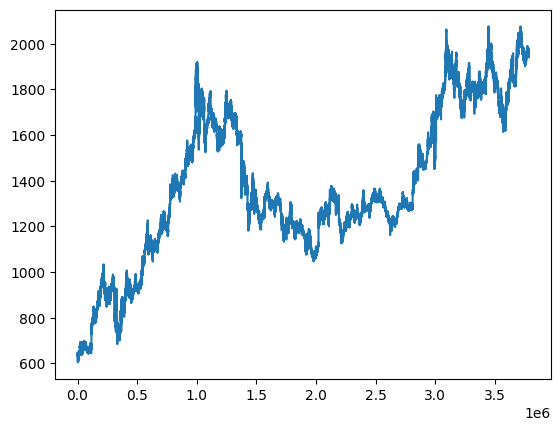

In [3]:
# simple Close price representation
df.Close.plot()
plt.show()

As you may notice, the default representation of Matplotlib show the evolution of @GC prices, but lacks many features: dates, unit of measure, interaction among them.

In order to represent the data in a clear way and interactive way, we need to reduce the level of granularity and use other representation tool such as Plotly. Further, we want to represent the data using candlesticks.

### Building Interactive Candlestick Chart

In [9]:
df = pd.read_csv("@GC_1min_Unadjusted.txt", 
                usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                parse_dates=[['Date', 'Time']],
                )
df.index = df['Date_Time']
df.drop(['Date_Time','Up','Down'], axis=1,inplace=True)

In [10]:
df.head(10)

,Open,High,Low,Close
Date_Time,,,,
2007-01-01 18:01:00,639.2,639.8,639.2,639.7
2007-01-01 18:02:00,639.8,640.3,639.8,640.3
2007-01-01 18:03:00,640.0,640.0,640.0,640.0
2007-01-01 18:04:00,639.9,640.0,639.6,639.9
2007-01-01 18:05:00,639.8,639.9,639.8,639.8
2007-01-01 18:06:00,639.8,640.1,639.5,640.0
2007-01-01 18:07:00,639.8,639.8,639.8,639.8
2007-01-01 18:11:00,639.8,639.9,639.8,639.9
2007-01-01 18:12:00,639.5,639.5,639.5,639.5


Here we build the dataset needed for the candlestick chart, but the granularity (1 min) is still too precise for a long term chart. In order to address thi issue we use the pandas resample function.

In [11]:
dailyOpen = df.Open.resample('D').first()
dailyHigh = df.High.resample('D').max()
dailyLow = df.Low.resample('D').min()
dailyClose = df.Close.resample('D').last()

NB: since dates and times of the dataset are based on exchange time, this means that resample function considers Sunday (trading hour from 18:00 to 00:00) as an independent day. We won't deal with this issue here, but keep it in mind.

In [12]:
my_O = pd.DataFrame(dailyOpen)
my_H = pd.DataFrame(dailyHigh)
my_L = pd.DataFrame(dailyLow)
my_C = pd.DataFrame(dailyClose)

matrix = my_O.merge(my_H, left_index=True, right_index=True)
matrix = matrix.merge(my_L, left_index=True, right_index=True)
matrix = matrix.merge(my_C, left_index=True, right_index=True)

matrix.dropna(inplace=True)

print('The new dataset contains',len(matrix),'records.')

The new dataset contains 5132 records.


In [13]:
matrix.head(10)

,Open,High,Low,Close
Date_Time,,,,
2007-01-01,639.2,640.3,638.5,639.8
2007-01-02,639.8,643.5,639.5,642.1
2007-01-03,642.1,647.3,627.0,630.8
2007-01-04,630.8,631.9,622.4,624.8
2007-01-05,625.2,627.9,603.1,608.5
2007-01-07,609.3,610.7,608.5,610.1
2007-01-08,610.2,614.9,605.0,614.0
2007-01-09,614.0,617.4,607.0,613.4
2007-01-10,613.2,614.5,606.2,610.0


Now, let's build the interactive candlestick chart!

In [15]:
fig = go.Figure( data = [go.Candlestick(x = matrix.index,
                        open  = matrix["Open"],
                        high  = matrix["High"],
                        low   = matrix["Low"],
                        close = matrix["Close"])],
                        )

fig.update_layout( title = dict(text = 'GC Daily Price',
                                font=dict(size=18, color='red'),
                                x=0.5,
                                ),
                        yaxis_title = "Price (log)",
                        xaxis_title = "Date",
                        xaxis_rangeslider_visible=False,
                        )

fig.update_xaxes(showline=True, 
                linewidth=2, 
                linecolor='black', 
                mirror=True,
                tickangle=-45,)

fig.update_yaxes(type="log",            # this add a logarithmic scale on the y axis
                showgrid=True,
                gridcolor='blue', griddash="longdash",
                showline=True, linewidth=2, 
                linecolor='black', mirror=True,)

fig.show()